# Part 2 EDA

In [223]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import plotly.express as px
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pymannkendall as mk


## View & Learn Data

In [104]:
# Import Metadata
metadata = pd.read_csv('Cleaned Data CSVs/weather_stations_list.csv')

metadata.head()

,station_id,name,latitude,longitude,elevation,country,provider
0,2979,Cap_ferrat,43.68333,7.32367,138,France,FR_METEOFRANCE
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS
4,2975,Dischingen_Eglingen,48.71340,10.44050,550,Germany,DE_DWD


In [105]:
# Import Station Data 
station_data = pd.read_csv('Cleaned Data CSVs/monthly_snowpack.csv')

station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


In [106]:
# station_data.describe()
print('Station Data Info')
print(station_data.info())
print('')

print(f'Station Data Shape {station_data.shape}')

print(f'Number Of Unique Entries = {station_data['id'].nunique()} ')

Station Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500100 entries, 0 to 1500099
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1500100 non-null  int64  
 1   station_id  1500100 non-null  int64  
 2   year        1500100 non-null  int64  
 3   month       1500100 non-null  int64  
 4   hnsum       1027301 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 57.2 MB
None

Station Data Shape (1500100, 5)
Number Of Unique Entries = 1500100 


In [107]:
# Drop Null Values
station_data = station_data.dropna()

station_data.describe(include='all')


,id,station_id,year,month,hnsum
count,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06
mean,1.068072e+06,1.489530e+03,1.990848e+03,6.405561e+00,1.941337e+01
std,4.381786e+05,8.584716e+02,1.802231e+01,3.521692e+00,3.985992e+01
min,3.714010e+05,1.000000e+00,1.864000e+03,1.000000e+00,0.000000e+00
25%,6.808710e+05,7.560000e+02,1.980000e+03,3.000000e+00,0.000000e+00
50%,1.045491e+06,1.494000e+03,1.993000e+03,6.000000e+00,0.000000e+00
75%,1.404724e+06,2.235000e+03,2.004000e+03,1.000000e+01,2.100000e+01
max,1.871500e+06,2.979000e+03,2.020000e+03,1.200000e+01,8.270000e+02


In [108]:
station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


## Clean & Organise Data

### Segergate by 'Winter' months

In [141]:
# Assess 'Winter Months' between November - April

station_data['winter'] = station_data['month'].isin([11, 12, 1, 2, 3, 4])

# Validate new column values

print('Number Of Winter Month Records = ',sum(station_data[station_data['winter']==True].value_counts()))

print('Number Of Summer Month Records =',sum(station_data[station_data['winter']==False].value_counts()))

print('Total Number Of Records = ',station_data.value_counts().sum())

Number Of Winter Month Records =  362616
Number Of Summer Month Records = 310429
Total Number Of Records =  673045


### Identify Weather Stations In European Alps



In [110]:

gdf_alps = gpd.read_file("/Users/mitchellpalmer/Projects/Europe_Snowpack_Depths/Raw Data CSVs/boundary_alps/AlpineConvention.shp")

gdf_alps

,OBJECTID,AREA,PERIMETER,NUEU1MV8_,NUEU1MV8_I,NUFTTP,NURGCDL3,NURGCDL2,NURGCDL1,NUCNCD,...,ROWID_1,ADCNCD,ADCNNM,ADCNPSEU,ADCNPSEF,ADCNPSCC,ADCNPSOC,SHAPE_Leng,SHAPE_Area,geometry
0,6830,0.398094,4.501714,8614,8676,M,AT213,AT21,AT2,AT,...,13,AT,AUSTRIA,T,F,F,F,4.501719,0.398094,"MULTIPOLYGON (((3893174.789 2365660.083, 38932..."


In [111]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(metadata["longitude"], metadata["latitude"])]
gdf_proj = gpd.GeoDataFrame(metadata, geometry=geometry, crs="EPSG:4326")  # WGS84 lat/lon


In [112]:
# Reproject station points to match the Alpine boundary CRS
gdf_proj = gdf_proj.to_crs(gdf_alps.crs)

# Filter station points inside Alpine region
stations_in_alps = gdf_proj[gdf_proj.within(gdf_alps.geometry.union_all())]

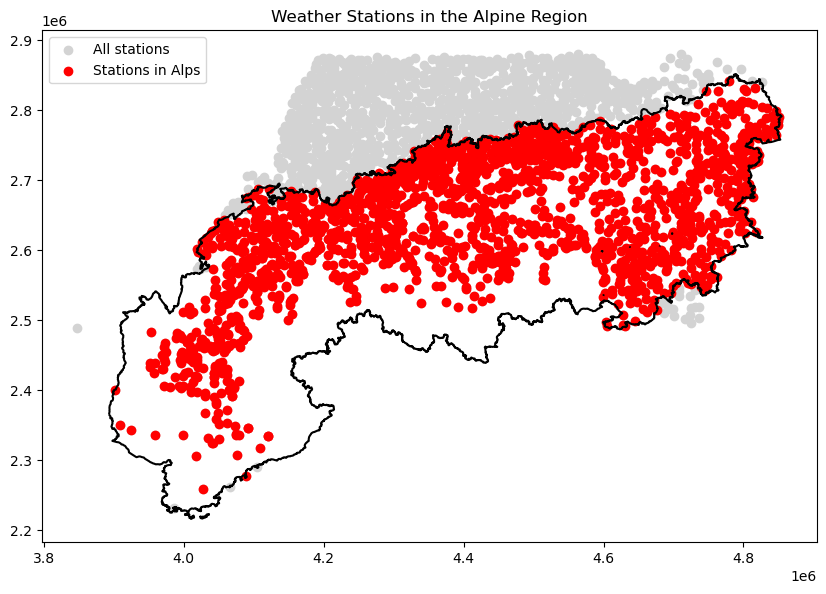

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
gdf_alps.boundary.plot(ax=ax, edgecolor='black')
gdf_proj.plot(ax=ax, color='lightgray', label='All stations')
stations_in_alps.plot(ax=ax, color='red', label='Stations in Alps')
plt.legend()
plt.title("Weather Stations in the Alpine Region")
plt.show()


In [114]:
stations_in_alps

,station_id,name,latitude,longitude,elevation,country,provider,geometry
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE,POINT (4046677.268 2380186.742)
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS,POINT (4099303.032 2615017.985)
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS,POINT (4261799.553 2587236.844)
7,2972,Prapoutel_38002404,45.25000,5.97467,1840,France,FR_METEOFRANCE,POINT (4004665.394 2468305.539)
8,2971,Val_casterino,44.09183,7.50350,1554,France,FR_METEOFRANCE,POINT (4120669.706 2334651.739)
...,...,...,...,...,...,...,...,...
2783,12,Podgorje,46.70639,15.81972,230,Slovenia,SI_ARSO,POINT (4765952.237 2638897.47)
2784,10,Sv_duh_na_ostrem_vrhu,46.61325,15.46336,870,Slovenia,SI_ARSO,POINT (4739498.012 2626504.276)
2786,8,Kozji_vrh,46.59917,15.26750,340,Slovenia,SI_ARSO,POINT (4724631.143 2623859.326)
2791,3,Megeve,45.85317,6.60483,1080,France,FR_METEOFRANCE,POINT (4057059.628 2532728.861)


### Data Filtering

Filter snowpack_depth recordings by Weather Stations In European Alps

In [115]:
# Create list of European Alp Weather Stations
stations_in_alps_list = stations_in_alps['station_id']

# Filter station_data to Weather Stations in Alps
station_data = station_data[station_data['station_id'].isin(stations_in_alps_list)]



### Assess Data Validity

Determine which years within our dataset meet thresholds to consider analysis

- Standard Error (SE) / Confidence Intervals
- Minimum Sample Size
    - Size = 30
- Coefficient of Variation (CV)
    - Compares the variability to the mean.
    - High CV in low-sample years means those averages are unstable.

Span of continuous reliable years: 1936 - 2019


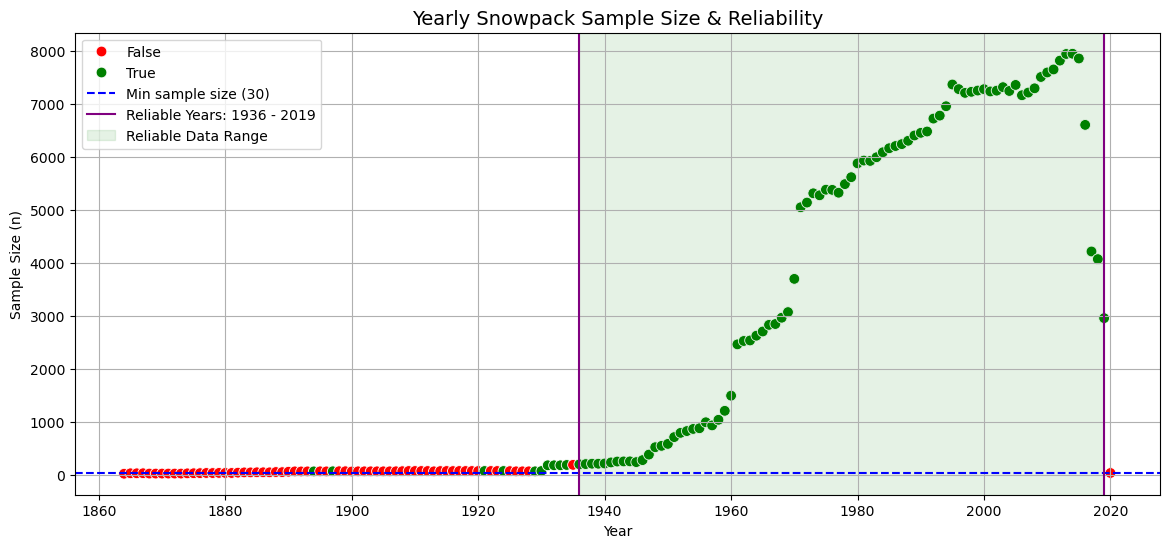

,year,n,mean,std,SE,CV,mean_change,Reliable
0,1864,15,23.733333,34.722300,8.965259,1.463018,NaN,False
1,1865,23,27.956522,36.283578,7.565649,1.297857,0.177943,False
2,1866,23,42.130435,47.987029,10.005987,1.139011,0.506998,False
3,1867,24,39.416667,55.106156,11.248497,1.398042,0.064413,False
4,1868,18,37.944444,47.327982,11.155312,1.247297,0.037350,False
...,...,...,...,...,...,...,...,...
152,2016,6598,41.549409,52.425408,0.645410,1.261761,0.413597,True
153,2017,4209,52.160846,54.493123,0.839948,1.044713,0.255393,True
154,2018,4065,46.993850,60.286408,0.945560,1.282857,0.099059,True
155,2019,2951,50.609963,55.952141,1.029988,1.105556,0.076949,True


In [188]:
# Assistance With AI

#  Aggregate Yearly Stats for Snowpack Depth
yearly_stats = station_data[station_data['winter']==True].groupby('year').agg(
    n=('hnsum', 'size'),
    mean=('hnsum', 'mean'),
    std=('hnsum', 'std')
).reset_index()

# Calculate Standard Error (SE) and Coefficient of Variation (CV)
yearly_stats['SE'] = yearly_stats['std'] / np.sqrt(yearly_stats['n']) # SE = Standard Deviation / (Square root of Sample size)
yearly_stats['CV'] = yearly_stats['std'] / yearly_stats['mean'] # CV = Standard Deviation / Average 

# Calculate year-to-year % change in mean snow depth
yearly_stats['mean_change'] = yearly_stats['mean'].pct_change().abs()

# Set Data Validity thresholds
min_sample_size = 30  # Minimum number of recordings per year
max_se_threshold = yearly_stats['SE'].median() * 1.5  # Allow 50% above median SE
mean_change_threshold = yearly_stats['mean'].mean() * 0.20  # 20% change allowed

# Assign Reliability flag
yearly_stats['Reliable'] = (
    (yearly_stats['n'] >= min_sample_size) &
    (yearly_stats['SE'] <= max_se_threshold) &
    (yearly_stats['mean_change'] <= mean_change_threshold)
)


# Assume yearly_stats['year'] is sorted
reliable_years = yearly_stats.loc[yearly_stats['Reliable'], 'year'].tolist()

# Identify an unbroken continous chain of 'Reliable Years' of data
earliest_reliable_year = None
latest_reliable_year = max(reliable_years) # Known Max() value is in continous chain
for i, start_year in enumerate(reliable_years):
    # Check if all years from start_year to max year are in the reliable list
    expected_years = list(range(start_year, max(reliable_years) + 1))
    if expected_years == reliable_years[i:]:
        earliest_reliable_year = start_year
        break

print(f"Span of continuous reliable years: {earliest_reliable_year} - {latest_reliable_year}")


# Plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=yearly_stats, x='year', y='n', hue='Reliable',
                palette={True: 'green', False: 'red'}, s=60)
plt.axhline(min_sample_size, color='blue', linestyle='--', label=f'Min sample size ({min_sample_size})')
plt.axvline(earliest_reliable_year, color='purple', linestyle='-', 
            label=f'Reliable Years: {earliest_reliable_year} - {latest_reliable_year}')
plt.axvline(latest_reliable_year, color='purple', linestyle='-')

# Shaded region for reliable years
plt.axvspan(earliest_reliable_year,latest_reliable_year, color='green', alpha=0.1,
            label="Reliable Data Range")

plt.title("Yearly Snowpack Sample Size & Reliability", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Sample Size (n)")
plt.legend()
plt.grid(True)
plt.show()

# --- Output the yearly stats for review ---
yearly_stats


### Data Filtering

#### Focus Range
Use identifed Focus_Range to isolate chosen sample data 

In [117]:
# Segregate the identiied Focus_Range
focus_range = np.arange(earliest_reliable_year,latest_reliable_year +1)
snow_recordings = station_data[(station_data['year'].isin(focus_range)) & (station_data['winter'] == True)]

# Sort by choronlogical order
snow_recordings = snow_recordings.sort_values(by=['year', 'month','station_id']).reset_index(drop=True)

pd.DataFrame(snow_recordings)
snow_recordings


,id,station_id,year,month,hnsum,winter
0,1784526,132,1936,1,37.0,True
1,1618609,153,1936,1,78.0,True
2,1733944,161,1936,1,19.0,True
3,1768395,313,1936,1,54.0,True
4,1775108,323,1936,1,63.0,True
...,...,...,...,...,...,...
358404,1442570,2911,2019,12,87.0,True
358405,1685437,2916,2019,12,72.0,True
358406,1823751,2929,2019,12,132.0,True
358407,1788563,2967,2019,12,61.0,True


#### Filter By Country

In [118]:
snow_recordings = pd.merge(snow_recordings, stations_in_alps, on='station_id')
snow_recordings

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.19 2631133.413)
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.91 2631072.969)
2,1733944,161,1936,1,19.0,True,Lugano,46.00423,8.96030,273,Switzerland,CH_METEOSWISS,POINT (4240369.378 2544041.935)
3,1768395,313,1936,1,54.0,True,Rigi_Kulm,47.05606,8.48503,1793,Switzerland,CH_METEOSWISS,POINT (4205810.806 2661457.227)
4,1775108,323,1936,1,63.0,True,Samedan_CH_METEOSWISS,46.52625,9.87945,1708,Switzerland,CH_METEOSWISS,POINT (4311741.13 2601445.781)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358404,1442570,2911,2019,12,87.0,True,Groste_,46.21773,10.88976,2265,Italy,IT_TN,POINT (4389730.961 2567592.475)
358405,1685437,2916,2019,12,72.0,True,Grachen,46.19532,7.83682,1605,Switzerland,CH_METEOSWISS,POINT (4153854.459 2567124.193)
358406,1823751,2929,2019,12,132.0,True,Zermatt_CH_METEOSWISS,46.02927,7.75244,1638,Switzerland,CH_METEOSWISS,POINT (4146801.979 2548889.336)
358407,1788563,2967,2019,12,61.0,True,Segl_Maria,46.43233,9.76231,1804,Switzerland,CH_METEOSWISS,POINT (4302712.064 2591038.323)


In [119]:
snow_recordings.value_counts('country')

country
Austria        123549
Switzerland     75001
Germany         55812
France          49998
Slovenia        37256
Italy           16793
Name: count, dtype: int64

### Filter by Elevation

#### Create Elevation Bands

In [126]:
snow_recordings['elevation'].describe()

count    358409.000000
mean        916.651209
std         501.648308
min           2.000000
25%         525.000000
50%         830.000000
75%        1250.000000
max        2964.000000
Name: elevation, dtype: float64

In [129]:
quartiles = np.quantile(snow_recordings['elevation'], [0.25, 0.5, 0.75])
Q1, median, Q3 = quartiles

def classify_elevation(elev):
    if elev <= Q1:
        return 'Low Elevation'
    elif Q1 < elev < Q3:
        return 'Mid Elevation'
    else:
        return 'High Elevation'
    
snow_recordings['elevation_band'] = snow_recordings['elevation'].apply(classify_elevation)

In [130]:
snow_recordings

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry,elevation_band
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.19 2631133.413),High Elevation
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.91 2631072.969),High Elevation
2,1733944,161,1936,1,19.0,True,Lugano,46.00423,8.96030,273,Switzerland,CH_METEOSWISS,POINT (4240369.378 2544041.935),Low Elevation
3,1768395,313,1936,1,54.0,True,Rigi_Kulm,47.05606,8.48503,1793,Switzerland,CH_METEOSWISS,POINT (4205810.806 2661457.227),High Elevation
4,1775108,323,1936,1,63.0,True,Samedan_CH_METEOSWISS,46.52625,9.87945,1708,Switzerland,CH_METEOSWISS,POINT (4311741.13 2601445.781),High Elevation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358404,1442570,2911,2019,12,87.0,True,Groste_,46.21773,10.88976,2265,Italy,IT_TN,POINT (4389730.961 2567592.475),High Elevation
358405,1685437,2916,2019,12,72.0,True,Grachen,46.19532,7.83682,1605,Switzerland,CH_METEOSWISS,POINT (4153854.459 2567124.193),High Elevation
358406,1823751,2929,2019,12,132.0,True,Zermatt_CH_METEOSWISS,46.02927,7.75244,1638,Switzerland,CH_METEOSWISS,POINT (4146801.979 2548889.336),High Elevation
358407,1788563,2967,2019,12,61.0,True,Segl_Maria,46.43233,9.76231,1804,Switzerland,CH_METEOSWISS,POINT (4302712.064 2591038.323),High Elevation


## Statistical Testing

### Mann_Kendal Test


- Output 
    - n : 
        - number of years tested for that group.
    - trend & p :
        - statistical significance of a monotonic increase/decrease.
    - tau :
        - strength of the monotonic relationship (direction via sign).
    - slope_per_year/decade :
        - estimated rate of change (Sen’s slope) in your units (e.g., cm of snow depth per year/decade).

In [145]:


results = []

# 1) aggregate: mean snow depth per month-year
month_year = (snow_recordings
              .groupby(['month', 'year'])['hnsum']
              .mean()
              .reset_index())

for m, g in month_year.groupby('month'):
    # 2) extract series for this month
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:  # simple guard
        results.append({'month': m, 'n': len(x), 'trend': 'insufficient', 'p': np.nan,
                        'tau': np.nan, 'slope_per_year': np.nan})
        continue

    # 3) run MK (original)
    res = mk.original_test(x)

    # 4) store
    results.append({
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_month_simple = pd.DataFrame(results).sort_values('month').reset_index(drop=True)
mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,1,84,no trend,0.095915,-0.123924,-0.219989,-2.199892
1,2,84,no trend,0.073678,-0.133104,-0.216468,-2.164683
2,3,84,no trend,0.423908,-0.059667,-0.093834,-0.938339
3,4,84,decreasing,0.009755,-0.192197,-0.175994,-1.759943
4,11,84,no trend,0.198301,-0.095812,-0.104533,-1.045331
5,12,84,no trend,0.077491,-0.131383,-0.250892,-2.508917


In [149]:

rows = []

# 1) aggregate: mean snow depth per (elev_band, month, year)
df_agg = (snow_recordings
          .groupby(['elevation_band','month','year'])['hnsum']
          .mean()
          .reset_index())

for (band, m), g in df_agg.groupby(['elevation_band','month']):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:
        rows.append({'elevation_band': band, 'month': m, 'n': len(x),
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # 3) MK (original to start; you can switch to hamed_rao if needed)
    res = mk.original_test(x)

    # 4) store
    rows.append({
        'elevation_band': band,
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_elev_month_simple = pd.DataFrame(rows).sort_values(['elevation_band','month']).reset_index(drop=True)
mk_elev_month_simple


,elevation_band,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,High Elevation,1,84,no trend,0.423908,-0.059667,-0.156647,-1.566475
1,High Elevation,2,84,no trend,0.099037,-0.122777,-0.289159,-2.891587
2,High Elevation,3,84,no trend,0.634673,-0.035571,-0.092234,-0.922344
3,High Elevation,4,84,no trend,0.068833,-0.135399,-0.238880,-2.388805
4,High Elevation,11,84,no trend,0.298725,-0.077453,-0.142102,-1.421018
5,High Elevation,12,84,no trend,0.355862,-0.068847,-0.212968,-2.129679
6,Low Elevation,1,84,decreasing,0.016968,-0.177567,-0.157471,-1.574710
7,Low Elevation,2,84,no trend,0.220726,-0.091222,-0.076237,-0.762367
8,Low Elevation,3,84,no trend,0.978426,-0.002295,-0.000323,-0.003235
9,Low Elevation,4,84,no trend,0.888985,0.010614,0.000000,0.000000


In [217]:

rows = []

# 1) aggregate: mean snow depth per (country, year)
df_agg = (snow_recordings
          .groupby(['country','year'])['hnsum']
          .mean()
          .reset_index())

for c, g in df_agg.groupby('country'):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)

    if n < 15:
        rows.append({'country': c, 'n': n, 'variant': 'original',
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # # 3a) MK original
    # res1 = mk.original_test(x)
    # rows.append({'country': c, 'n': n, 'variant': 'original',
    #              'trend': res1.trend, 'p': res1.p, 'tau': res1.Tau,
    #              'slope_per_year': res1.slope, 'slope_per_decade': res1.slope*10})

    # 3b) MK Hamed–Rao (autocorr-adjusted)
    res2 = mk.hamed_rao_modification_test(x)
    rows.append({'country': c, 'n': n, 'variant': 'hamed_rao',
                 'trend': res2.trend, 'p': res2.p, 'tau': res2.Tau,
                 'slope_per_year': res2.slope, 'slope_per_decade': res2.slope*10})

mk_country_simple = pd.DataFrame(rows).sort_values(['country','variant']).reset_index(drop=True)
mk_country_simple


,country,n,variant,trend,p,tau,slope_per_year,slope_per_decade
0,Austria,47,hamed_rao,no trend,0.108950,-0.147086,-0.183605,-1.836051
1,France,61,hamed_rao,no trend,0.732155,0.030601,0.066089,0.660885
2,Germany,83,hamed_rao,no trend,0.675640,0.034969,0.044912,0.449116
3,Italy,48,hamed_rao,no trend,0.092989,-0.168440,-0.326450,-3.264503
4,Slovenia,59,hamed_rao,decreasing,0.006520,-0.243717,-0.199945,-1.999451
5,Switzerland,84,hamed_rao,no trend,0.217828,-0.091796,-0.080532,-0.805319


In [ ]:
# Alternative AI Provided custom_function for Mann_Kendall testing. Learn the concepts

def mann_kendall_by_group(
    df: pd.DataFrame,
    group_cols,                     # e.g., ['elevation_band','month'] or ['country']
    time_col: str = 'year',
    value_col: str = 'hnsum',
    agg: str = 'mean',
    min_length: int = 10,
    variant: str = 'original',      # 'original' | 'seasonal' | 'hamed_rao' | 'yue_wang'
    period: int = 12,
    slope_per: str = 'decade'       # 'year' or 'decade'
) -> pd.DataFrame:

    if isinstance(group_cols, str):
        group_cols = [group_cols]

    df2 = df.copy()
    grouped = (
        df2.groupby(group_cols + [time_col], dropna=False)[value_col]
           .agg(agg).reset_index()
    )

    rows = []
    for keys, g in grouped.groupby(group_cols, dropna=False):
        g = g.sort_values(time_col)
        x = g[value_col].to_numpy(dtype=float)

        # drop NaNs but keep order
        x = x[~np.isnan(x)]
        if len(x) < min_length:
            d = {col: val for col, val in zip(group_cols, keys if isinstance(keys, tuple) else (keys,))}
            d.update(dict(n=len(x), trend='insufficient', p=np.nan, tau=np.nan,
                          slope_per_year=np.nan, z=np.nan))
            d[f'slope_per_{slope_per}'] = np.nan
            rows.append(d)
            continue

        if variant == 'original':
            res = mk.original_test(x)
        elif variant == 'seasonal':
            res = mk.seasonal_test(x, period=period)
        elif variant == 'hamed_rao':
            res = mk.hamed_rao_modification_test(x)
        elif variant == 'yue_wang':
            res = mk.yue_wang_modification_test(x)
        else:
            raise ValueError("variant must be one of: 'original','seasonal','hamed_rao','yue_wang'")

        slope_per_year = res.slope
        slope_scaled = slope_per_year if slope_per == 'year' else slope_per_year * 10.0

        d = {col: val for col, val in zip(group_cols, keys if isinstance(keys, tuple) else (keys,))}
        d.update(dict(
            n=len(x),
            trend=res.trend,      # 'increasing' | 'decreasing' | 'no trend'
            p=res.p,
            tau=res.Tau,
            slope_per_year=slope_per_year,
            z=getattr(res, 'z', np.nan)
        ))
        d[f'slope_per_{slope_per}'] = slope_scaled
        rows.append(d)

    out = pd.DataFrame(rows).sort_values(group_cols).reset_index(drop=True)
    return out


In [142]:
mk_month = mann_kendall_by_group(
    snow_recordings,
    group_cols=['month'],
    time_col='year',
    value_col='hnsum',
    agg='median',
    min_length=15,
    variant='original',
    slope_per='decade'
)
mk_month

,month,n,trend,p,tau,slope_per_year,z,slope_per_decade
0,1,84,decreasing,0.039454,-0.153184,-0.257289,-2.059425,-2.572892
1,2,84,no trend,0.077419,-0.131383,-0.205931,-1.765861,-2.059313
2,3,84,no trend,0.390937,-0.063970,-0.095696,-0.857919,-0.956960
3,4,84,no trend,0.080772,-0.129662,-0.076340,-1.746227,-0.763403
4,11,84,no trend,0.128352,-0.113024,-0.108402,-1.520631,-1.084019
5,12,84,decreasing,0.008406,-0.195927,-0.292893,-2.635301,-2.928932


## Visualisations

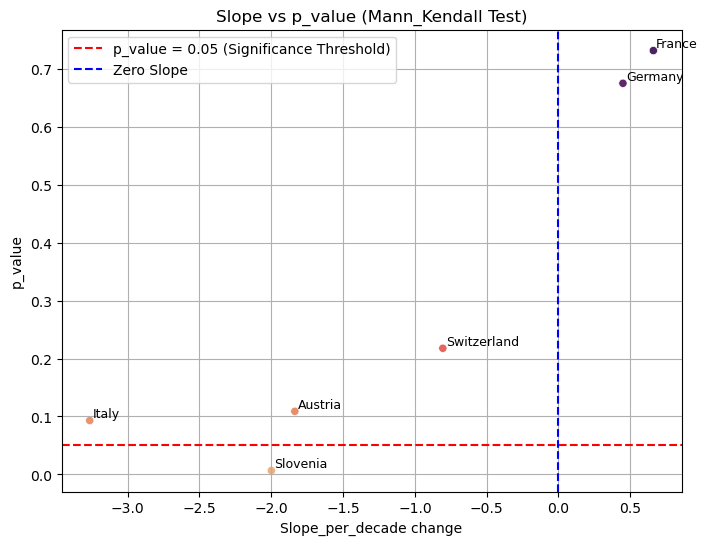

In [ ]:
fig1, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_country_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the country name
for i, row in mk_country_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['country'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

In [243]:
month_labels = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    11:'Nov',
    12:'Dec'
}

def get_month_name(month_number):
    """
    Converts a month number to an abbreviated month name using a custom dictionary

    Args:
        month_number (int): The number representing the month (1 for January, 12 for December).

    Returns:
        str: The abbreviated name of the month, or "Invalid month number" if out of range.
    """
    if 1 <= month_number <= 12:
        return month_labels[month_number]
    else:
        return "Invalid month number"


mk_month_simple['month_name'] = mk_month_simple['month'].apply(get_month_name)

mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade,month_name
0,1,84,no trend,0.095915,-0.123924,-0.219989,-2.199892,Jan
1,2,84,no trend,0.073678,-0.133104,-0.216468,-2.164683,Feb
2,3,84,no trend,0.423908,-0.059667,-0.093834,-0.938339,Mar
3,4,84,decreasing,0.009755,-0.192197,-0.175994,-1.759943,Apr
4,11,84,no trend,0.198301,-0.095812,-0.104533,-1.045331,Nov
5,12,84,no trend,0.077491,-0.131383,-0.250892,-2.508917,Dec


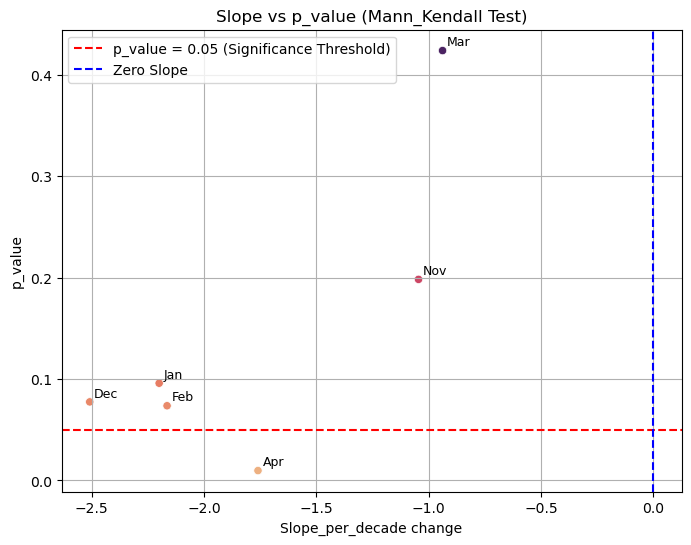

In [242]:

fig, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_month_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the month name
for i, row in mk_month_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['month_name'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

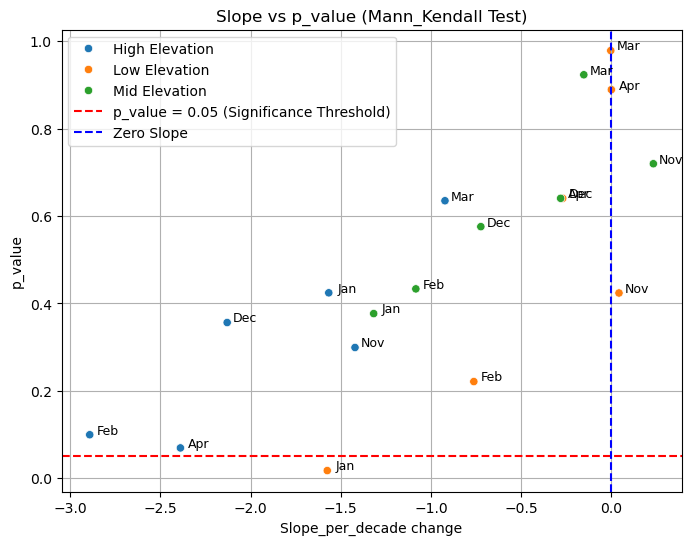

In [263]:
mk_elev_month_simple['month_name'] = mk_elev_month_simple['month'].apply(get_month_name)


fig2, ax2 = plt.subplots(figsize=(8,6))



sns.scatterplot(data=mk_elev_month_simple, x='slope_per_decade',y='p',hue='elevation_band', ax=ax2 )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

for i, row in mk_elev_month_simple.iterrows():
    ax2.text(
        row['slope_per_decade'] +0.1 ,
        row['p'] + 0.01,
        row['month_name'],        # Display month
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        fontweight='normal'
    )


ax2.legend()
ax2.set_ylabel('p_value')
ax2.set_xlabel('Slope_per_decade change')
ax2.set_title('Slope vs p_value (Mann_Kendall Test)')
ax2.grid(True)

plt.show()